In [63]:
%pylab inline
import pandas as pd
import nibabel as nib
from pbr.config import config as cc
from os.path import join, exists, split
import nipype.pipeline.engine as pe
from nipype.interfaces.slicer import SimpleRegionGrowingSegmentation
import nipype.interfaces.utility as niu
import nipype.interfaces.fsl as fsl
import nipype.interfaces.ants as ants
import nipype.interfaces.io as nio
import itertools

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [32]:
from nipype.utils.filemanip import fname_presuffix

In [33]:
fname_presuffix?

In [105]:
def getSRGS(inputv, seeds, multiplier=1.0, 
            nbhd = 1, iterations=5, timestep = 0.0625,
            smoothingiterations=5):
    import os
    from subprocess import check_call
    from nipype.utils.filemanip import fname_presuffix
    outputv = fname_presuffix(inputv, newpath=os.path.abspath("."), suffix="_{}_{}_{}_{}_{}".format(multiplier,
                                                                                                   nbhd, iterations,
                                                                                                   timestep, 
                                                                                                    smoothingiterations))
    cmd = ["SimpleRegionGrowingSegmentation", inputv, 
           outputv, "--multiplier", str(multiplier),
          "--neighborhood", str(nbhd),
          "--iterations", str(iterations),
          "--timestep", str(timestep),
          "--smoothingIterations", str(smoothingiterations)]
    cmd += ["--seed", "{},{},{}".format(s[0], s[1], s[2])]
    check_call(cmd)
    return ouptputv

In [106]:
df = pd.read_csv("/data/henry7/PBR/subjects/mse2441/mindcontrol/\
ms1244-mse2441-002-AX_T1_3D_IRSPGR/align/rois/ms1244-mse2441-002-AX_T1_3D_IRSPGR-veovibes.csv",
                index_col=0)

--neighborhood <int>
     The radius of the neighborhood over which to calculate intensity model
     (default: 1)

   --multiplier <double>
     Number of standard deviations to include in intensity model (default:
     2.5)

   --iterations <int>
     Number of iterations of region growing (default: 5)

   --timestep <double>
     Timestep for curvature flow (default: 0.0625)

   --smoothingIterations <int>
     Number of smoothing iterations (default: 5)


In [107]:
coords = [[row.x, row.y, row.z] for i, row in df.iterrows()]
input_file = "/data/henry7/PBR/subjects/mse2441/alignment/ms1244-mse2441-002-AX_T1_3D_IRSPGR.nii.gz"
output_file = "/data/henry7/PBR/subjects/mse2441/lesion_grow/ms1244-mse2441-002-AX_T1_3D_IRSPGR.nii.gz"

In [108]:
multipliers = [1.4]#linspace(1,1.5,5)
iterators = [5,20]
nbhds = [1]#,2]
timestep = [0.0625]#, 0.0625/2]
smoothings = [5]#,20]

In [109]:
data = [q for q in itertools.product(multipliers, iterators, nbhds, timestep, smoothings)]
parameters = pd.DataFrame(data, columns = ["multiplier", "iterations", "nbhd", "timestep", "smoothingiterations"])
parameters.head()

,multiplier,iterations,nbhd,timestep,smoothingiterations
0,1.4,5,1,0.0625,5
1,1.4,20,1,0.0625,5


In [110]:
parameters.shape

(2, 5)

In [111]:
def get_workflow(parameters):
    wf = pe.Workflow(name="regionGrowing")
    wf.base_dir = "/scratch/henry_temp/keshavan/region_growing_test"
    n = pe.Node(niu.Function(input_names=["inputv", "seeds", "multiplier", 
                "nbhd", "iterations", "timestep",
                "smoothingiterations"], output_names=["outfile"],
                            function=getSRGS),
               name="srgs")
    inputspec = pe.Node(niu.IdentityInterface(fields=["seeds", "in_file"]), name="inputspec")
    n.iterables = [(q, parameters[q].tolist()) for q in ["multiplier", 
                "nbhd", "iterations", "timestep",
                "smoothingiterations"]]
    wf.connect(inputspec, "seeds", n, "seeds")
    wf.connect(inputspec, "in_file", n, "inputv")

    dt = pe.Node(fsl.ChangeDataType(output_datatype="short"), name="changedt")
    wf.connect(n,"outfile", dt, "in_file")

    stats = pe.Node(fsl.ImageStats(args="-c"), name="stats")
    wf.connect(dt, "out_file", stats, "in_file")

    avg = pe.JoinNode(ants.AverageImages(dimension=3), 
                      name="average",
                     joinsource="changedt",
                     joinfield=["images"])
    wf.connect(dt, "out_file", avg, "images")
    outputspec = pe.Node(niu.IdentityInterface(fields=["avg_image"]), name="outputspec")
    return wf, inputspec, outputspec

In [112]:
mwf = pe.Workflow(name="region_growing_meta")
mwf.base_dir = "/scratch/henry_temp/keshavan/region_growing_test"
for c in coords:
    wf, inp, out = get_workflow(parameters)
    inp.inputs.in_file = input_file
    inp.inputs.seeds = c
    mwf.add_nodes([wf])
    break

In [113]:
mwf.write_graph()

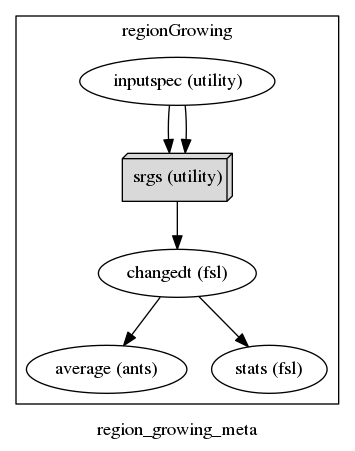

In [114]:
from IPython.display import Image
Image("/scratch/henry_temp/keshavan/region_growing_test/region_growing_meta/graph.dot.png")

In [115]:
mwf.run()

RuntimeError: Workflow did not execute cleanly. Check log for details